# TME10 - Variational Auto-Encoder

In [6]:

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.utils.data
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.utils.tensorboard import SummaryWriter

from tqdm import tqdm_notebook as tqdm
from itertools import chain


In [2]:
import torchvision.datasets as datasets
tr = transforms.Compose([transforms.ToTensor(),
#                          transforms.Normalize(mean=0., std=256.), # already normalized
                         transforms.Lambda(lambda x: x.view(-1)),      #flatten
                         transforms.Lambda(lambda x: (x>0.5).float()), # to binary
                        ])
mnist_trainset = datasets.MNIST(root='~/datasets/', train= True, download=True, transform=tr)
mnist_testset  = datasets.MNIST(root='~/datasets/', train=False, download=True, transform=tr)


In [3]:
batch_size = 256

train_dataloader = DataLoader(mnist_trainset, shuffle=True, batch_size=batch_size)
X_test, y_test = zip(*mnist_testset)
test_dataoader = torch.stack(X_test, dim=0), torch.tensor(y_test)
 
print('train : ', len(train_dataloader), next(iter(train_dataloader))[0].shape)
print('test  : ', test_dataoader[0].shape)

train :  235 torch.Size([256, 784])
test  :  torch.Size([10000, 784])


## Models :

In [4]:
normal_sampler = torch.distributions.normal.Normal(torch.zeros(1).squeeze(), torch.ones(1).squeeze())
def sample_normal(mu, logsigma):
    return mu + torch.exp(.5*logsigma) * normal_sampler.sample(logsigma.shape)
    

def log_pdf_normal(mu, logsigma, x):
    """log du pdf de loi normale """
    return -0.5*( logsigma + np.log(2*np.pi)+ (x-mu)**2/torch.exp(logsigma) )

def kl(mu, logsigma, reduce=True):
    x = -0.5*torch.sum(1+logsigma-mu**2-torch.exp(logsigma), dim=-1)
    if reduce:
        return x.mean(0)
    return x

In [5]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super().__init__()
        self.latent_dim = latent_dim
        self.l0 = nn.Linear(input_dim, hidden_dim)
        self.l1 = nn.Linear(hidden_dim, latent_dim*2)
    def forward(self, x):
        """ returns tuple of :
        **z** : latent variable sampled from distribution, 
        **mu** : center parameter,
        **logsigma** : log(sigma**2) std parameter,
        """
        x = self.l0(x)
        x = F.relu(x)
        x = self.l1(x).view(-1,2*self.latent_dim)
        mu, logsigma = x[:, :self.latent_dim], x[:, self.latent_dim:]
        z = sample_normal(mu, logsigma)
        return z, mu, logsigma
    def sample(self, mu, logsigma):
        return sample_normal(mu, logsigma)

    
class DecoderNormal(nn.Module):
    """ en niveaux de gris on modélise les probas de chaque sortie par loi normales en omettant que x in [0,1]"""
    def __init__(self, output_dim, hidden_dim, latent_dim):
        super().__init__()
        self.output_dim = output_dim
        self.l0 = nn.Linear(latent_dim, hidden_dim)
        self.l1 = nn.Linear(hidden_dim, 2*output_dim)
    def forward(self, x):
        """ returns tuple of :
        **mu** : center parameter,
        **logsigma** : log(sigma**2) std parameter,
        """
        x = self.l0(x)
        x = F.relu(x)
        x = self.l1(x).view(-1,2*self.output_dim)
        mu, logsigma = x[:, :self.output_dim], x[:, self.output_dim:]
        mu  = torch.sigmoid(mu)
        return mu, logsigma
    def sample(self, mu, logsigma):
        return sample_normal(mu, logsigma)

    
class DecoderBernoulli(nn.Module):
    """ en niveaux NetB on modélise les probas de chaque sortie par loi de bernoulli"""
    def __init__(self, output_dim, hidden_dim, latent_dim):
        super().__init__()
        self.output_dim = output_dim
        self.l0 = nn.Linear(latent_dim, hidden_dim)
        self.l1 = nn.Linear(hidden_dim, output_dim)
        self.uni = torch.distributions.uniform.Uniform(0,1)
    def forward(self, x):
        """ returns tuple of :
        **p** : bernoulli law parameter (proba of being 1),
        """
        x = self.l0(x)
        x = F.relu(x)
        x = self.l1(x).view(-1,self.output_dim)
        p  = torch.sigmoid(x)
        return p
    def sample(self, p):
        return (self.uni.sample(p.shape) < p).float()

    
    

In [6]:
## display :
def to_pic(tensor):
    return tensor.view(-1,1,28,28)

In [ ]:
### TRAINING ###
input_dim  = 784
hidden_dim = 100
latent_dim = 2

lr_encoder = 2e-3
lr_decoder = 5e-3

lbd_kl = 1e-2

min_log_d = -12

encoder = Encoder(input_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
# decoder = DecoderNormal( input_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = DecoderBernoulli(input_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
# optimizer = torch.optim.Adam(chain(encoder.parameters(), decoder.parameters()))
optim_encoder = torch.optim.Adam(encoder.parameters(), lr=lr_encoder)
optim_decoder = torch.optim.Adam(decoder.parameters(), lr=lr_decoder)
writer = SummaryWriter(comment='_VAE_d{}'.format(latent_dim), log_dir='./runs_tme10')

N = 20
test_freq = 10
pic_freq = 1

step = 0
for i in tqdm(range(N), desc='epochs'):
    for j,(x,y_target) in enumerate(tqdm(train_dataloader, desc='batchs')):
        z, mu_e, logs_e = encoder(x)
        
#         mu_d, logs_d = decoder(z)
#         logs_d = torch.clamp(logs_d, min_log_d, 10000)
#         loglikelihood = log_pdf_normal(mu_d, logs_d, x).sum(-1).mean(0)
        p = decoder(z)
#         x_bin = (x>0.5).float()
        x_bin = x
        loglikelihood = torch.log(p*x_bin + (1-p)*(1-x_bin)).sum(-1).mean(0)
        
        kl_penalty = kl(mu_e, logs_e)
        loss = -loglikelihood + lbd_kl*kl_penalty
        optim_encoder.zero_grad()
        optim_decoder.zero_grad()
        loss.backward()
        optim_encoder.step()
        optim_decoder.step()
        step += 1

        writer.add_scalar('-loglikelihood', -loglikelihood, step)
        writer.add_scalar('kl_penalty', kl_penalty, step)
        writer.add_scalar('loss', loss, step)
#         writer.add_histogram('mu_e', mu_e.detach(), step)
#         writer.add_histogram('mu_d', mu_d.detach(), step)
#         writer.add_histogram('logs_e',logs_e.detach(), step)
#         writer.add_histogram('logs_d',logs_d.detach(), step)
        writer.flush()
    
    
    if i%pic_freq==0:
        y_idx_pic = np.unique(y_target.numpy(), return_index=True)
        for y_pic, idx_pic in zip(*y_idx_pic):
            pics = to_pic(torch.stack([x[idx_pic]]+[decoder.sample(p)[idx_pic] for _ in range(5)], dim=0))
            if torch.isnan(pics).any():
                print("nan picture")
                break
            pics = torch.clamp(pics, 0, 1)
            writer.add_images('pics_{}'.format(int(y_pic)), pics, step)
            writer.flush()
    

In [11]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [12]:
import tensorflow as tf
import datetime, os

In [1]:
%tensorboard --logdir runs

UsageError: Line magic function `%tensorboard` not found.


runs_tme10/Jan23_19-31-51_pierre-pc_VAE_d20/events.out.tfevents.1579804311.pierre-pc.4154.10
runs_tme10/Jan23_19-37-15_pierre-pc_VAE_d10/events.out.tfevents.1579804635.pierre-pc.4154.11
runs_tme10/Jan23_19-43-48_pierre-pc_VAE_d2/events.out.tfevents.1579805028.pierre-pc.4154.12
runs_tme10/Jan23_20-04-45_pierre-pc_VAE_d2/events.out.tfevents.1579806285.pierre-pc.4154.13
runs_tme10/Jan23_20-16-03_pierre-pc_VAE_d10/events.out.tfevents.1579806963.pierre-pc.4154.14
runs_tme10/Jan23_20-30-00_pierre-pc_VAE_d20/events.out.tfevents.1579807800.pierre-pc.4154.15


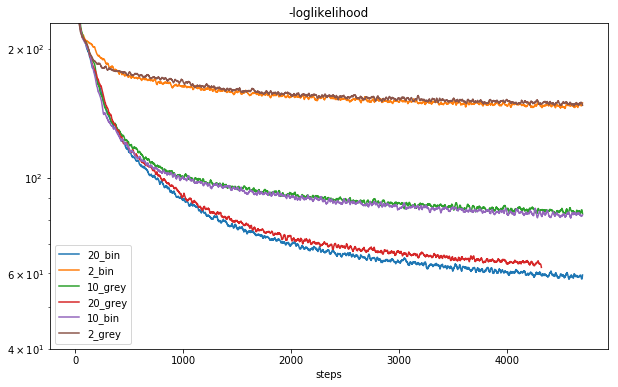

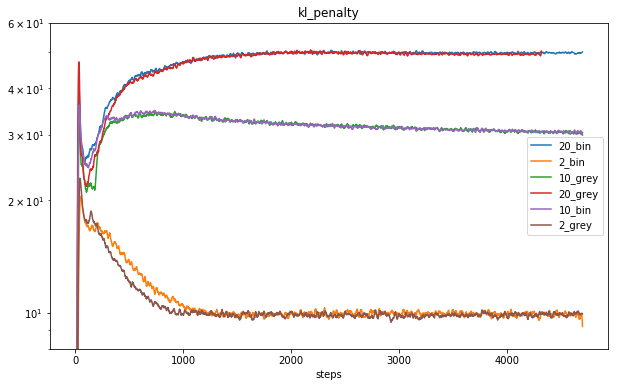

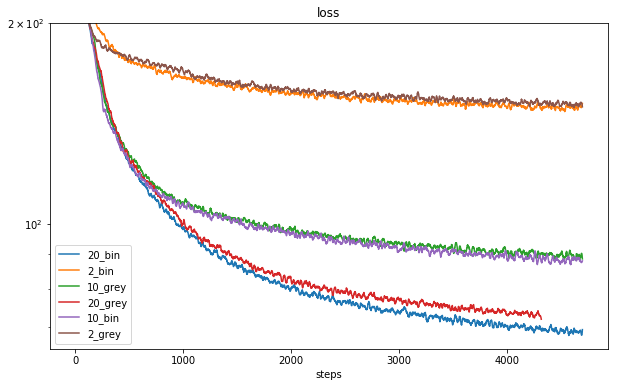

In [23]:
## Retrieve curves from tensorboard :

from tme_gym.utils_rdl import read_runs_dir
from scipy.signal import savgol_filter

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10, 6)


!ls runs_tme10/*/*
corres = {
    'runs_tme10/Jan23_19-31-51_pierre-pc_VAE_d20/events.out.tfevents.1579804311.pierre-pc.4154.10':'20_grey',
    'runs_tme10/Jan23_19-37-15_pierre-pc_VAE_d10/events.out.tfevents.1579804635.pierre-pc.4154.11':'10_grey',
    'runs_tme10/Jan23_19-43-48_pierre-pc_VAE_d2/events.out.tfevents.1579805028.pierre-pc.4154.12':'2_grey',
    'runs_tme10/Jan23_20-04-45_pierre-pc_VAE_d2/events.out.tfevents.1579806285.pierre-pc.4154.13':'2_bin',
    'runs_tme10/Jan23_20-16-03_pierre-pc_VAE_d10/events.out.tfevents.1579806963.pierre-pc.4154.14':'10_bin',
    'runs_tme10/Jan23_20-30-00_pierre-pc_VAE_d20/events.out.tfevents.1579807800.pierre-pc.4154.15':'20_bin',
}
keys = ['-loglikelihood', 'kl_penalty', 'loss']
curves = read_runs_dir('runs_tme10/', keys)

k = '-loglikelihood'
for path, v in curves.items():
    x,y = v[k]
    y = savgol_filter(y, 31, 3) ## smoothing
    plt.plot(x,y, label=corres[path])
plt.title(k)
plt.ylim(40, 230)
plt.yscale('log')
plt.xlabel('steps')
plt.legend()
plt.show()

k = 'kl_penalty'
for path, v in curves.items():
    x,y = v[k]
    y = savgol_filter(y, 31, 3) ## smoothing
    plt.plot(x,y, label=corres[path])
plt.title(k)
plt.yscale('log')
plt.ylim(8, 60)
plt.xlabel('steps')
plt.legend()
plt.show()


k = 'loss'
for path, v in curves.items():
    x,y = v[k]
    y = savgol_filter(y, 31, 3) ## smoothing
    plt.plot(x,y, label=corres[path])
plt.title(k)
plt.yscale('log')
plt.ylim(65, 200)
plt.xlabel('steps')
plt.legend()
plt.show()

En **gris** on observe les courbes d'apprentissage (loss, - loglikelihood et pénalité kl) 
pour un état latent de taille 2 (`mu.shape=(2,)` et  `logsigma.shape=(2,)`). 
En **vert** un état latent de taille 10 et en **rouge** une taille 20. 
Ces 3 jeux de courbes ont été obtenus avec en entrée de l'enccodeur des images en **niveaux de gris**. 

Dans l'onglet *IMAGES* de tensorboard, on constate que le résultat obtenu est très satisfaisant
pour la taille 20 et relativement bien pour la taille 10 mais assez aproximatif pour la taille 2.



Les courbes **orange**, **violet** et **bleu** montrent les résultats des mêmes experiences mais avec des images d'entrée **binaires** (avec un seuil à 0.5). 
On ne constate pas de différence entre les résultats avec entrée binaire et avec entrée en niveaux de gris.


J'ai aussi essayé de modéliser l'encodeur tel qu'il génère les paramètres de lois normales pour obtenir des images en niveaux de gris en sortie. 
Mais l'entraînement était très instable.
Quand que un des sigmas était trop petit et que une erreur était commise, la log-vraisemblance chutait drastiquement. L'entraînement aboutissait systématiquenet en des `NaN`.   